# Analysing gradient receptive fields of neurons in V4 monkeys

This notebook is about analysing what most strongly activates neurons in V4 and what pixels in an image have to change in order to stimulate the neuron. The gradient RFs are calculated for individual images and individual neurons.

Overview of the notebook:

* extracting neurons with the best test correlation
* example-based visualization: plots images that were leading to the strongest/weakest activation of a specific neuron
* plotting gradient receptive fields of neurons (with respect to input image!). This should show which parts of an image are most relevant for the activation of the neuron, such that a change of the relevant parts would most probably also lead to a change in activation.

In [1]:
%load_ext autoreload
%autoreload 

import numpy as np
from numpy.linalg import eig
from numpy.linalg import solve
import matplotlib.pyplot as plt
import matplotlib.colors as mat_col
import torch

import nnfabrik
from nnfabrik import builder


import numpy as np
import pickle
import os

from os import listdir
from os.path import isfile, join

import matplotlib.pyplot as plt

import nnvision

import datajoint as dj
dj.config['enable_python_native_blobs'] = True


dj.config['database.user']= 'kanderer'
dj.config['database.password']= 'enamel-vendetta-deodorant'


schema_name = 'nnfabrik_monkey_saliency'

schema = dj.schema(schema_name, locals())
dj.config['nnfabrik.schema_name'] = schema_name

from nnfabrik.main import *

Connecting kanderer@134.2.168.16:3306


In [2]:
import datajoint as dj

dj.config['enable_python_native_blobs'] = True

from nnfabrik.templates.trained_model import TrainedModelBase
from nnfabrik.main import *
import os

if not 'stores' in dj.config:
    dj.config['stores'] = {}
    
dj.config['stores']['minio'] = {  # store in s3
    'protocol': 's3',
    'endpoint': os.environ.get('MINIO_ENDPOINT', 'DUMMY_ENDPOINT'),
    'bucket': 'nnfabrik',
    'location': 'dj-store',
    'access_key': os.environ.get('MINIO_ACCESS_KEY', 'FAKEKEY'),
    'secret_key': os.environ.get('MINIO_SECRET_KEY', 'FAKEKEY')
}

In [3]:
basepath = '/data/monkey/toliaslab/CSRF19_V4'
neuronal_data_path = os.path.join(basepath, 'neuronal_data/')
neuronal_data_files = [neuronal_data_path + f for f in listdir(neuronal_data_path) if isfile(join(neuronal_data_path, f))]
image_cache_path = os.path.join(basepath, 'images')

saliency_cache_path = os.path.join(basepath, 'images_saliency')
print(saliency_cache_path)

/data/monkey/toliaslab/CSRF19_V4/images_saliency


In [4]:
@schema
class TrainedModel(TrainedModelBase):
    table_comment = "Trained models"
    storage = "minio"
    model_table = Model
    dataset_table = Dataset
    trainer_table = Trainer
    seed_table = Seed
    user_table = Fabrikant

### Loading a already trained CNN model with a Gaussian readout

In [5]:
key = dict(model_hash='cec63aa4435b2a205ec02eafc0a745ee', dataset_hash='ce98e82c2543a503de7611648340380e', trainer_hash = 'f03a6527ab0422767da50e67e2d543ef')

dataloader, model = (TrainedModel & key).load_model()

In [6]:
model

Encoder(
  (core): SE2dCore(
    (_input_weights_regularizer): LaplaceL2norm(
      (laplace): Laplace()
    )
    (features): Sequential(
      (layer0): Sequential(
        (conv): Conv2d(1, 32, kernel_size=(15, 15), stride=(1, 1), bias=False)
        (norm): BatchNorm2d(32, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
        (nonlin): ELU(alpha=1.0, inplace=True)
      )
      (layer1): Sequential(
        (ds_conv): DepthSeparableConv2d(
          (in_depth_conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (spatial_conv): Conv2d(32, 32, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4), groups=32, bias=False)
          (out_depth_conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        )
        (norm): BatchNorm2d(32, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
        (nonlin): ELU(alpha=1.0, inplace=True)
      )
      (layer2): Sequential(
        (ds_conv): DepthSeparableConv2d(
          

### Get the best neurons based on test correlation scores

In [7]:
from nnvision.tables.scores import TestCorrelationScore
from nnvision.tables.main import Recording
from nnvision.tables.scores import TestCorrelationScoreEnsemble

In [8]:
Recording.Units.fetch()

Recording.populate()

In [9]:
best_five = (Recording.Units*TestCorrelationScore.Units & key).fetch("data_key", "unit_id","unit_index", "unit_test_correlation",limit=5, order_by="unit_test_correlation DESC", as_dict=True)

In [10]:
best_100 = (Recording.Units*TestCorrelationScore.Units & key).fetch("data_key", "unit_id","unit_index", "unit_test_correlation",limit=100, order_by="unit_test_correlation DESC", as_dict=True)#best_5 = (TestCorrelationScore.Units & key).fetch("KEY", "unit_test_correlation", limit=5, order_by="unit_test_correlation DESC")

In [11]:
best_five

[{'data_key': '3649689088057',
  'unit_id': 7,
  'unit_index': 5,
  'unit_test_correlation': 0.78306},
 {'data_key': '3649689088057',
  'unit_id': 3,
  'unit_index': 2,
  'unit_test_correlation': 0.679932},
 {'data_key': '3648644839726',
  'unit_id': 8,
  'unit_index': 5,
  'unit_test_correlation': 0.634252},
 {'data_key': '3648051669051',
  'unit_id': 4,
  'unit_index': 2,
  'unit_test_correlation': 0.62688},
 {'data_key': '3653061170515',
  'unit_id': 9,
  'unit_index': 6,
  'unit_test_correlation': 0.610875}]

### Extracting a list of images and the neuron responses:

In [12]:
#extracts the images were the 7 neurons with best test correlation were trained on:


### the neuron with the best test correlation and the neuron with the second best test correlation were recorded 
### in the same session, therefore they were 'trained' on the same images: train_images1
train_images1 = []
targets_list1 = []
for batch in dataloader["train"]['3649689088057']:
    images = batch.inputs
    responses = batch.targets

    for i in range(0, images.shape[0]):
        train_images1.append(images[i])
        targets_list1.append(responses[i])
    
train_images3 = []
targets_list3 = []
for batch in dataloader["train"]['3648644839726']:
    images = batch.inputs
    responses = batch.targets

    for i in range(0, images.shape[0]):
        train_images3.append(images[i])
        
        targets_list3.append(responses[i])

train_images4 = []
targets_list4 = []
for batch in dataloader["train"]['3648051669051']:
    images = batch.inputs
    responses = batch.targets

    for i in range(0, images.shape[0]):
        train_images4.append(images[i])
        
        targets_list4.append(responses[i])
    
    
train_images5 = []
targets_list5 = []
for batch in dataloader["train"]['3653061170515']:
    images = batch.inputs
    responses = batch.targets

    for i in range(0, images.shape[0]):
        train_images5.append(images[i])
        
        targets_list5.append(responses[i])
    


train_images6 = []
targets_list6 = []
for batch in dataloader["train"]['3653061170515']:
    images = batch.inputs
    responses = batch.targets

    for i in range(0, images.shape[0]):
        train_images6.append(images[i])
        
        targets_list6.append(responses[i])
    
print(len(targets_list6))



9789


### Example based visualizeation approach:

What were the images that activated the neurons most? Can we maybe see a pattern from there?

target response tensor(27.)
target response tensor(25.)
target response tensor(24.)
target response tensor(23.)
target response tensor(22.)
target response tensor(21.)
target response tensor(20.)
target response tensor(19.)
target response tensor(18.)
target response tensor(17.)
target response tensor(16.)
target response tensor(15.)


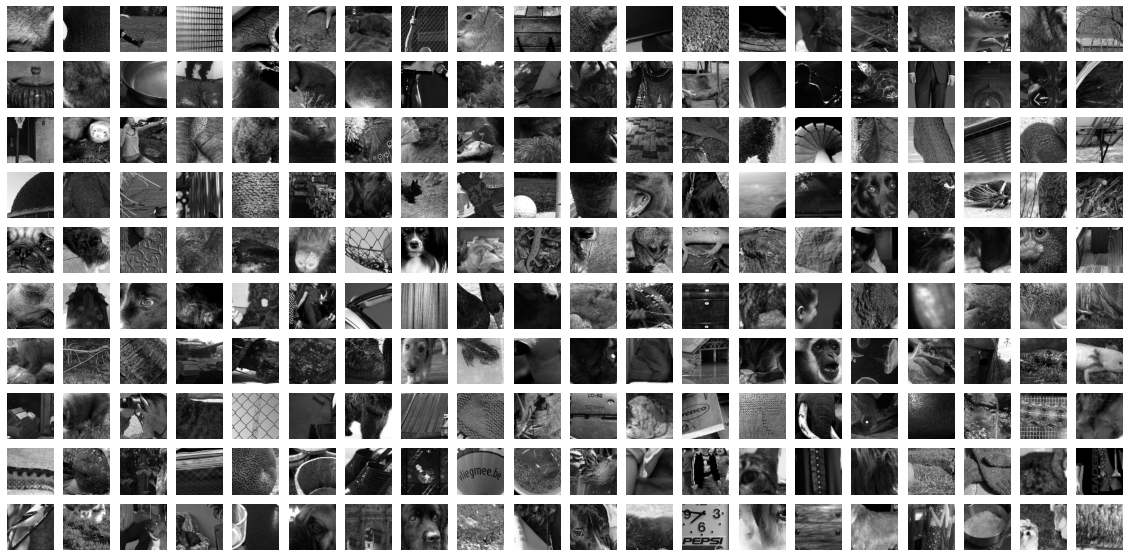

In [13]:
## plot the 200 images that excited neuron 1 (neuron with best test correlation best strongly)

best_images_neuron1 = []
target_neuron_1 = []

activations = []
for index in range(0, len(train_images1)):
    activations.append(targets_list1[index][5])
    
sorted_act = sorted(activations)   

max_values = []
for i in range (1, 201):
    max_value = sorted_act[-i]
    if max_value not in max_values:
        max_values.append(max_value)
        print('target response', max_value)

        indices = [i for i, x in enumerate(np.vstack(targets_list1)[:,5]) if x == max_value]

        for index in indices:
            best_images_neuron1.append(train_images1[index])
            target_neuron_1.append(targets_list1[index][5])
            
fig, axs = plt.subplots(10, 20, figsize=(20,10))

i = 0
for k in range(0, 10):
    for p in range(0, 20):
        axs[k][p].imshow(best_images_neuron1[i].squeeze(0), cmap='gray')
        axs[k][p].axis('off')
        i+=1
        
plt.savefig('200_most_activated_img_for_neuron_best_testcorr.png')

target response tensor(18.)
target response tensor(17.)
target response tensor(16.)
target response tensor(15.)
target response tensor(14.)
target response tensor(13.)


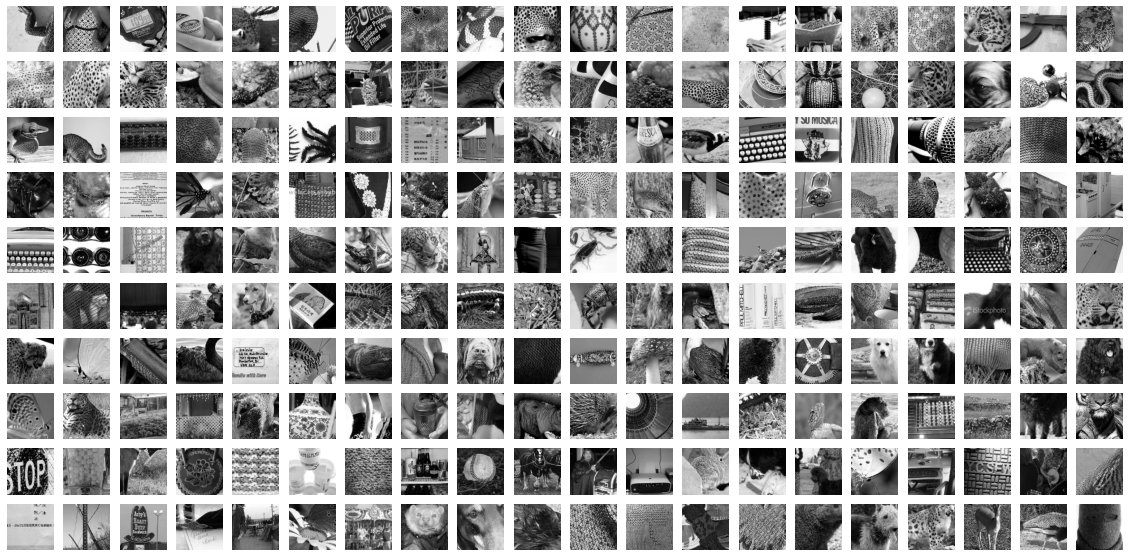

In [14]:
best_images_neuron2 = []
target_neuron_2_best = []

activations = []
for index in range(0, len(train_images1)):
    activations.append(targets_list1[index][2])
    
sorted_act = sorted(activations)   

max_values = []
for i in range (1, 201):
    max_value = sorted_act[-i]
    if max_value not in max_values:
        max_values.append(max_value)
        print('target response', max_value)
        indices = [i for i, x in enumerate(np.vstack(targets_list1)[:,2]) if x == max_value]

        for index in indices:
            best_images_neuron2.append(train_images1[index])
            target_neuron_2_best.append(max_value)
     
            
    
fig, axs = plt.subplots(10, 20, figsize=(20,10))

i = 0
for k in range(0, 10):
    for p in range(0, 20):
        axs[k][p].imshow(best_images_neuron2[i].squeeze(0), cmap='gray')
        i+=1
        axs[k][p].axis('off')
        
plt.savefig('200_best_img_third_best_neuron.png')

tensor(0.)


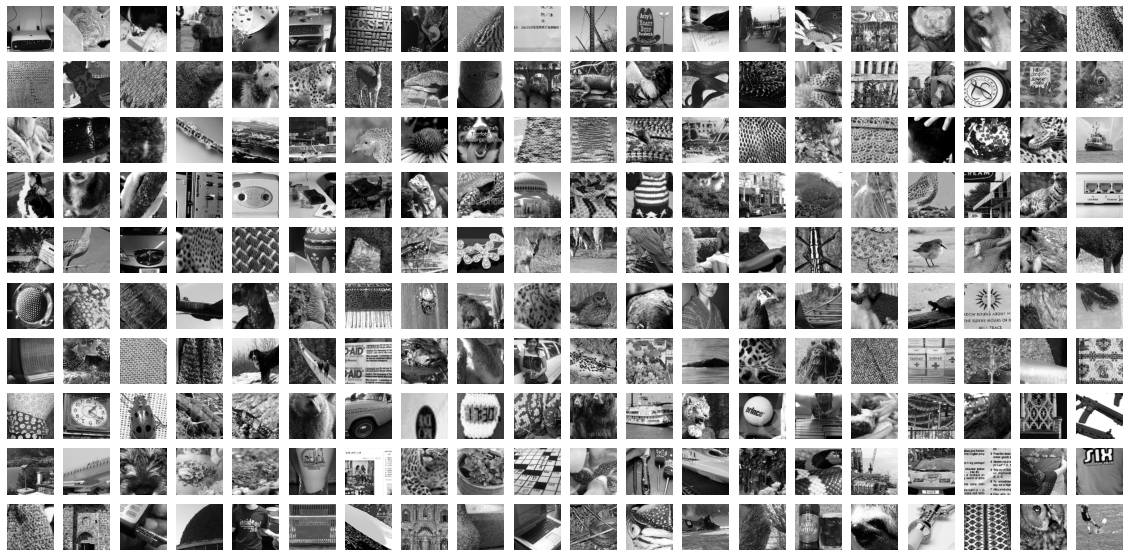

In [57]:
#### what about images that don't lead to an activation?

worst_images_neuron1 = []
target_neuron_1_worst = []

activations = []
for index in range(0, len(train_images1)):
    activations.append(targets_list1[index][5])
    
sorted_act = sorted(activations)   

min_values = []
for i in range (1, 201):
    min_value = sorted_act[i]
    if min_value not in min_values:
        min_values.append(min_value)
        print(min_value)
        indices = [i for i, x in enumerate(np.vstack(targets_list1)[:,5]) if x == min_value]

        for index in indices:
            worst_images_neuron1.append(train_images1[index])
            target_neuron_1_worst.append(min_value)
     
            
    
fig, axs = plt.subplots(10, 20, figsize=(20,10))

i = 0
for k in range(0, 10):
    for p in range(0, 20):
        axs[k][p].imshow(worst_images_neuron2[i].squeeze(0), cmap='gray')
        i+=1
        axs[k][p].axis('off')
        
#plt.savefig('200_worst_img_third_best_neuron.png')

tensor(0.)
tensor(1.)


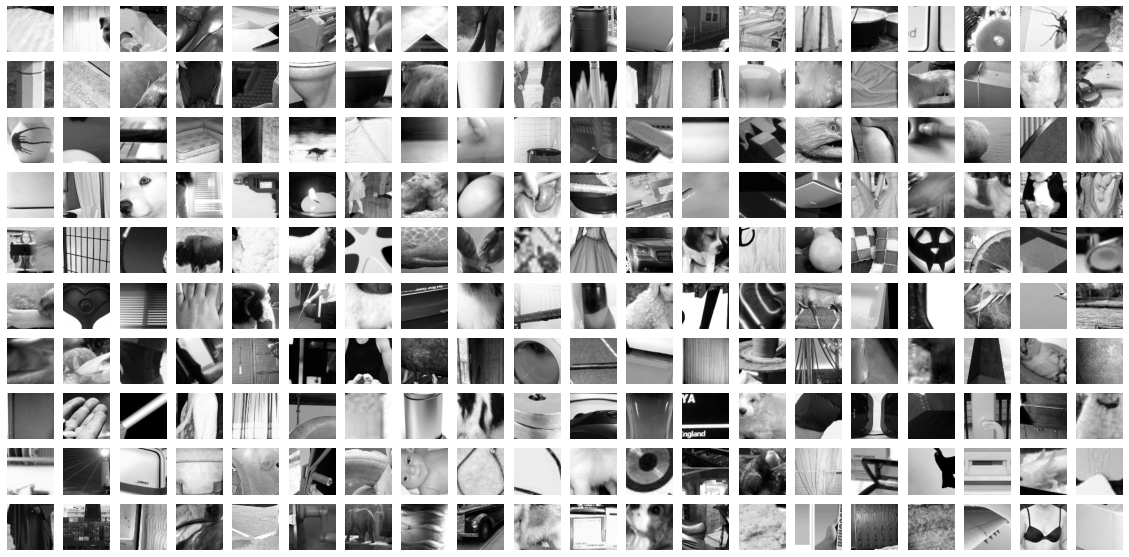

In [58]:
#### what about images that don't lead to an activation?

worst_images_neuron2 = []
target_neuron_2_worst = []

activations = []
for index in range(0, len(train_images1)):
    activations.append(targets_list1[index][2])
    
sorted_act = sorted(activations)   

min_values = []
for i in range (1, 201):
    min_value = sorted_act[i]
    if min_value not in min_values:
        min_values.append(min_value)
        print(min_value)
        indices = [i for i, x in enumerate(np.vstack(targets_list1)[:,2]) if x == min_value]

        for index in indices:
            worst_images_neuron2.append(train_images1[index])
            target_neuron_2_worst.append(min_value)
     
            
    
fig, axs = plt.subplots(10, 20, figsize=(20,10))

i = 0
for k in range(0, 10):
    for p in range(0, 20):
        axs[k][p].imshow(worst_images_neuron2[i].squeeze(0), cmap='gray')
        i+=1
        axs[k][p].axis('off')
        
#plt.savefig('200_worst_img_third_best_neuron.png')

### What about the gRFs of the images that were leading to no/weak responses?

#### Let's see how the neuron with the best test correlation behaves:

In [69]:

best = {'data_key': '3649689088057',
  'unit_id': 7,
  'unit_index': 5,
  'unit_test_correlation': 0.78306}

n_neurons = 1

    
#iterates through the 7 neurons with the best test correlation, selects the right session with ['data_key']
j = 0

images = worst_images_neuron1     #taking same images for every neuron 

RFs_worst1 = torch.zeros(n_neurons, n_images,*images[0].shape[1:]) # preallocating RFs

img_x, img_y = images[0].shape[1:] # x and y dim on the image


for i in range(0, n_images):
    x = images[i].reshape((1,1,images[i].shape[1], images[i].shape[2]))

    x = x.clone().detach().requires_grad_(True).to('cpu')
    optimizer = torch.optim.Adam([x], lr = 1.0)
    optimizer.zero_grad()

    r = model(x, data_key=best['data_key'], pretrained=True)


    r[0, best['unit_index']].backward(retain_graph=True)
    RFs_worst1[j, i] = x.grad.data

    x.grad.data.zero_()

#### Plots some example images for the gradient receptive fields of the images that were leading to no/weak response (neuron 1):

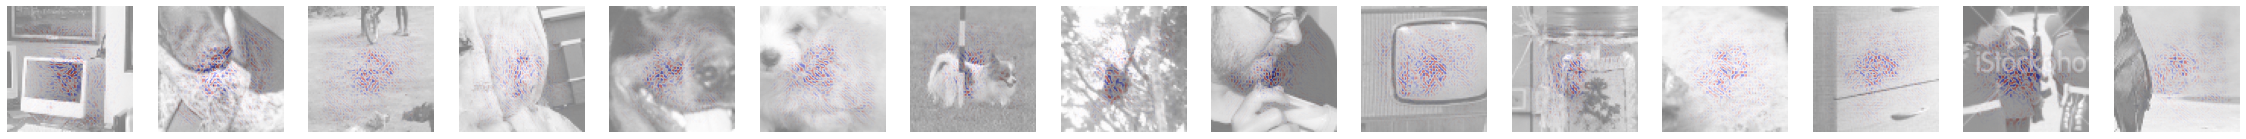

In [76]:
fig, axs = plt.subplots(1, 15, figsize=(40,5))
j = 0 #neuron
i = 0
max_transparency = 0.65
images = worst_images_neuron1 

threshold_value = 1e-4 # only values above that will be shown. I guess it's the best to the the np.abs(gradRF) when setting the alphas to zero

i = 0

for k in range(0, 15):
   
    image = RFs_worst1[0, k].cpu().detach().numpy().squeeze()
    
    max_intensity=np.max(np.abs(image))
    min_intensity=np.min(np.abs(image))



    alpha_values = np.ones_like(image) * max_transparency
    threshold_value = np.percentile(np.abs(image), 10)
    
    
    ## sets the values below the threshold to zero, so that they won't get plotted.
    alpha_values[np.abs(image)<threshold_value] = 0

    axs[k].imshow(image , alpha=alpha_values, cmap="seismic", vmin=-max_intensity, vmax = max_intensity)
    axs[k].imshow(images[k].squeeze(0) ,cmap=  'gray', alpha = 0.5)
    axs[k].axis('off')
    

plt.savefig('gRF_leading_to_weakest_response_neuron1.png')

In [67]:
n_neurons = 1

    
#iterates through the 7 neurons with the best test correlation, selects the right session with ['data_key']
j = 0

images = best_images_neuron1     #taking same images for every neuron 

RFs_best1 = torch.zeros(n_neurons, n_images,*images[0].shape[1:]) # preallocating RFs

img_x, img_y = images[0].shape[1:] # x and y dim on the image

#images = dataloader["train"][best['data_key']].dataset[:].inputs
for i in range(0, n_images):
    x = images[i].reshape((1,1,images[i].shape[1], images[i].shape[2]))

    x = x.clone().detach().requires_grad_(True).to('cpu')
    optimizer = torch.optim.Adam([x], lr = 1.0)
    optimizer.zero_grad()

    r = model(x, data_key=best['data_key'], pretrained=True)


    r[0, best['unit_index']].backward(retain_graph=True)
    RFs_best1[j, i] = x.grad.data

    x.grad.data.zero_()
j += 1

#### Plots some example images for the gradient receptive fields of the images that were leading to strongest response (neuron 1):

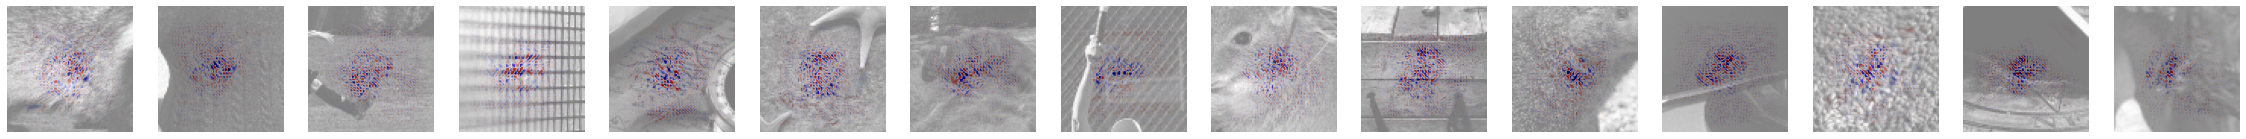

In [68]:
fig, axs = plt.subplots(1, 15, figsize=(40,5))
j = 0 #neuron
i = 0
max_transparency = 0.65
images = best_images_neuron1 
threshold_value = 1e-4 # only values above that will be shown. I guess it's the best to the the np.abs(gradRF) when setting the alphas to zero

i = 0

for k in range(0, 15):
   
    image = RFs_best1[0, k].cpu().detach().numpy().squeeze()
    
    max_intensity=np.max(np.abs(image))
    min_intensity=np.min(np.abs(image))



    alpha_values = np.ones_like(image) * max_transparency
    threshold_value = np.percentile(np.abs(image), 10)
    
    
    ## sets the values below the threshold to zero, so that they won't get plotted.
    alpha_values[np.abs(image)<threshold_value] = 0

    axs[k].imshow(image , cmap="seismic", vmin=-max_intensity, vmax = max_intensity)
    axs[k].imshow(images[k].squeeze(0) ,cmap=  'gray', alpha = 0.5)
    axs[k].axis('off')
    
plt.savefig('gRF_leading_to_strongest_response_neuron1.png')

### Now let's do the same analysis for the nruon with the second best test correlation:

In [71]:
n_images = 200 # 100 images would also be fine

best = {'data_key': '3649689088057',
  'unit_id': 3,
  'unit_index': 2,
  'unit_test_correlation': 0.679932}

n_neurons = 1

    
#iterates through the 7 neurons with the best test correlation, selects the right session with ['data_key']
j = 0

images = worst_images_neuron2     #taking same images for every neuron 

RFs_worst2 = torch.zeros(n_neurons, n_images,*images[0].shape[1:]) # preallocating RFs

img_x, img_y = images[0].shape[1:] # x and y dim on the image


for i in range(0, n_images):
    x = images[i].reshape((1,1,images[i].shape[1], images[i].shape[2]))

    x = x.clone().detach().requires_grad_(True).to('cpu')
    optimizer = torch.optim.Adam([x], lr = 1.0)
    optimizer.zero_grad()

    r = model(x, data_key=best['data_key'], pretrained=True)


    r[0, best['unit_index']].backward(retain_graph=True)
    RFs_worst2[j, i] = x.grad.data

    x.grad.data.zero_()


#### Plots some example images for the gradient receptive fields of the images that were leading to no/weak response (neuron 2):

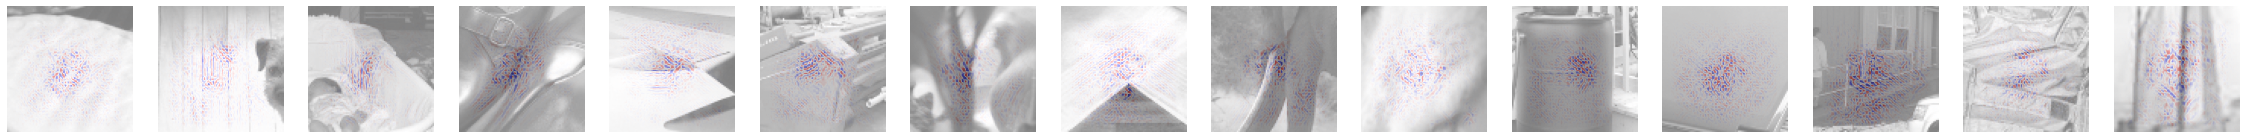

In [75]:
fig, axs = plt.subplots(1, 15, figsize=(40,5))
j = 0 #neuron
i = 0
max_transparency = 0.65
images = worst_images_neuron2 

threshold_value = 1e-4 # only values above that will be shown. I guess it's the best to the the np.abs(gradRF) when setting the alphas to zero

i = 0

for k in range(0, 15):
   
    image = RFs_worst2[0, k].cpu().detach().numpy().squeeze()
    
    max_intensity=np.max(np.abs(image))
    min_intensity=np.min(np.abs(image))



    alpha_values = np.ones_like(image) * max_transparency
    threshold_value = np.percentile(np.abs(image), 10)
    
    
    ## sets the values below the threshold to zero, so that they won't get plotted.
    alpha_values[np.abs(image)<threshold_value] = 0

    axs[k].imshow(image , alpha=alpha_values, cmap="seismic", vmin=-max_intensity, vmax = max_intensity)
    axs[k].imshow(images[k].squeeze(0) ,cmap=  'gray', alpha = 0.5)
    axs[k].axis('off')
    

plt.savefig('gRF_leading_to_weakest_response_neuron2.png')

In [73]:
### now the same for best images of neuron 2:
n_images = 200 # 100 images would also be fine

best = {'data_key': '3649689088057',
  'unit_id': 3,
  'unit_index': 2,
  'unit_test_correlation': 0.679932}

n_neurons = 1

    
#iterates through the 7 neurons with the best test correlation, selects the right session with ['data_key']
j = 0

images = best_images_neuron2     #taking same images for every neuron 

RFs_best2 = torch.zeros(n_neurons, n_images,*images[0].shape[1:]) # preallocating RFs

img_x, img_y = images[0].shape[1:] # x and y dim on the image

#images = dataloader["train"][best['data_key']].dataset[:].inputs
for i in range(0, n_images):
    x = images[i].reshape((1,1,images[i].shape[1], images[i].shape[2]))

    x = x.clone().detach().requires_grad_(True).to('cpu')
    optimizer = torch.optim.Adam([x], lr = 1.0)
    optimizer.zero_grad()

    r = model(x, data_key=best['data_key'], pretrained=True)


    r[0, best['unit_index']].backward(retain_graph=True)
    RFs_best2[j, i] = x.grad.data

    x.grad.data.zero_()
j += 1

#### Plots the gradient receptive fields of the images that were leading to the strongest response (neuron 2)

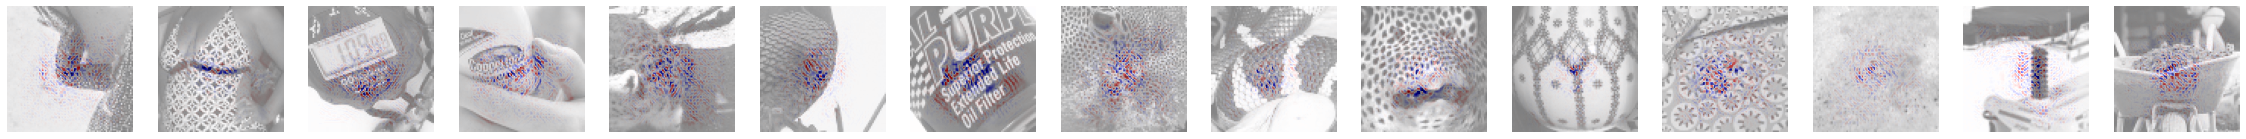

In [74]:
fig, axs = plt.subplots(1, 15, figsize=(40,5))
j = 0 #neuron
i = 0
max_transparency = 0.65
images = best_images_neuron2 
threshold_value = 1e-4 # only values above that will be shown. I guess it's the best to the the np.abs(gradRF) when setting the alphas to zero

i = 0

for k in range(0, 15):
   
    image = RFs_best2[0, k].cpu().detach().numpy().squeeze()
    
    max_intensity=np.max(np.abs(image))
    min_intensity=np.min(np.abs(image))



    alpha_values = np.ones_like(image) * max_transparency
    threshold_value = np.percentile(np.abs(image), 10)
    
    
    ## sets the values below the threshold to zero, so that they won't get plotted.
    alpha_values[np.abs(image)<threshold_value] = 0

    axs[k].imshow(image , cmap="seismic", vmin=-max_intensity, vmax = max_intensity)
    axs[k].imshow(images[k].squeeze(0) ,cmap=  'gray', alpha = 0.5)
    axs[k].axis('off')
    
plt.savefig('gRF_leading_to_strongest_response_neuron2.png')

### Looking at the distributions of the values of the gradient receptive fields:

#### Comparison between distribution of gRF of images that were leading to weakest versus images that were leading to strongest activation

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

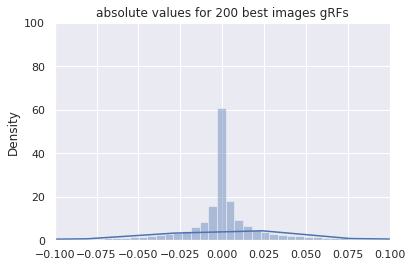

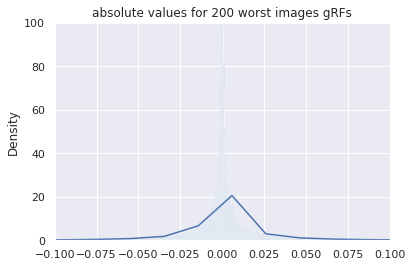

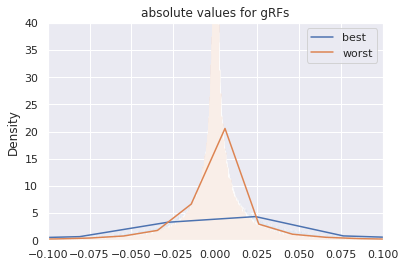

In [79]:
best_array = []
worst_array = []

for k in range(0, 200):
    best = RFs_best1[0][k].cpu().detach().numpy().squeeze()
    worst = RFs_worst1[0][k].cpu().detach().numpy().squeeze()
    
    best_array.append(best)
    worst_array.append(worst)
    
    
import seaborn as sns
import pandas as pd
sns.set()
plt.figure()
sns.distplot(best_array, bins = 2000)
plt.xlim(-0.1, 0.1)
plt.ylim(0, 100)
plt.title('absolute values for 200 best images gRFs')
plt.savefig('values_dist__best')

plt.figure()
sns.distplot(worst_array, bins = 20000)
plt.xlim(-0.1, 0.1)
plt.ylim(0, 100)
#plt.hist(best_max)
#plt.hist(worst_max)

#plt.legend(('best', 'worst'))
plt.title('absolute values for 200 worst images gRFs')
plt.savefig('values_dist__worst')

best_min = []
worst_min = []


plt.figure()
sns.distplot(best_array, bins = 50000)
sns.distplot(worst_array, bins = 50000)
plt.xlim(-0.1, 0.1)
plt.ylim(0, 40)
#plt.hist(best_max)
#plt.hist(worst_max)
plt.title('absolute values for gRFs')
plt.legend(('best', 'worst'))

plt.savefig('absolute_vals')

In [53]:
np.percentile(best_array, 90)

0.03202373497188092

#### Looking at some more example-based visualization examples of different neurons:

tensor(13.)
tensor(12.)
tensor(11.)
tensor(10.)
tensor(9.)
tensor(8.)
tensor(7.)
tensor(6.)
tensor(5.)


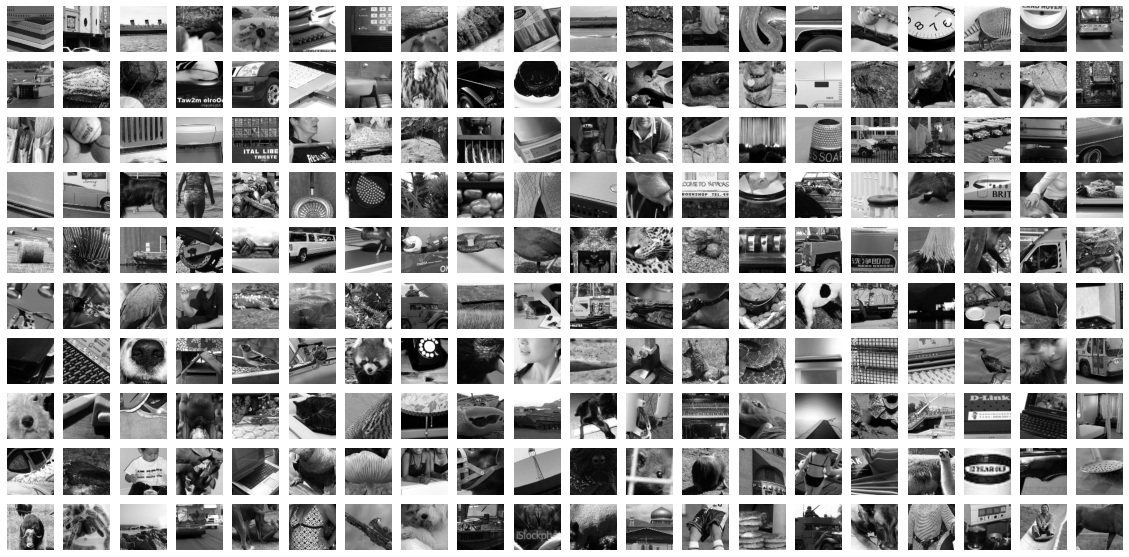

In [21]:
best_images_neuron3 = []
target_neuron_3 = []



activations = []
for index in range(0, len(train_images3)):
    activations.append(targets_list3[index][5])
    
sorted_act = sorted(activations)   

max_values = []
for i in range (1, 201):
    max_value = sorted_act[-i]
    if max_value not in max_values:
        max_values.append(max_value)
        print(max_value)
        indices = [i for i, x in enumerate(np.vstack(targets_list3)[:,5]) if x == max_value]

        for index in indices:
            best_images_neuron3.append(train_images3[index])
            target_neuron_3.append(targets_list3[index][5])
     
            
    
fig, axs = plt.subplots(10, 20, figsize=(20,10))

i = 0
for k in range(0, 10):
    for p in range(0, 20):
        axs[k][p].imshow(best_images_neuron3[i].squeeze(0), cmap='gray')
        i+=1
        axs[k][p].axis('off')
        
plt.savefig('200_best_img_third_best_neuron.png')

tensor(12.)
tensor(10.)
tensor(9.)
tensor(8.)
tensor(7.)
tensor(6.)
tensor(5.)


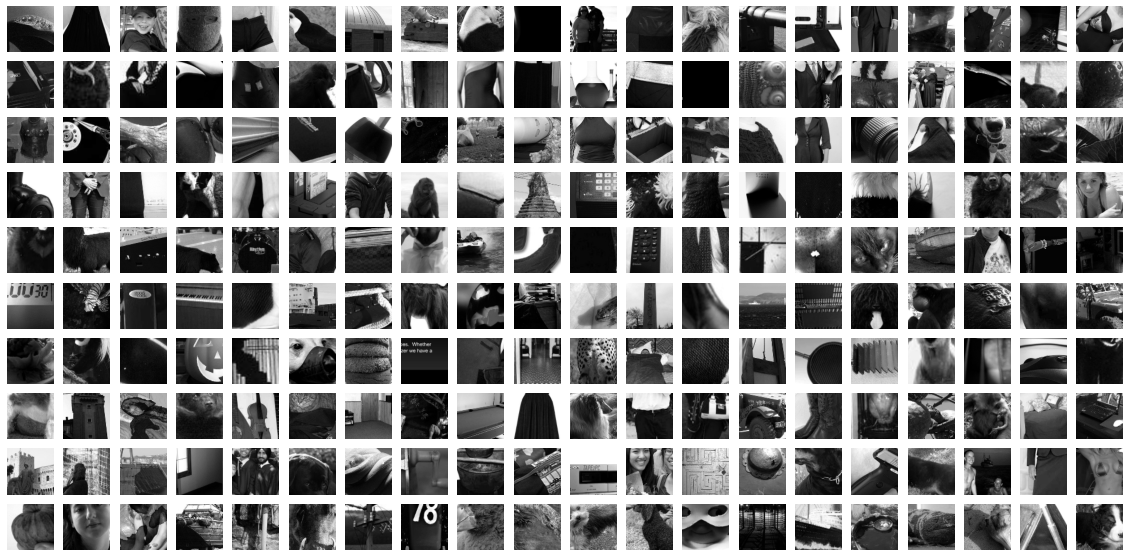

In [41]:
best_images_neuron4 = []
target_neuron_4 = []



activations = []
for index in range(0, len(train_images4)):
    activations.append(targets_list4[index][2])
    
sorted_act = sorted(activations)   

max_values = []
for i in range (1, 201):
    max_value = sorted_act[-i]
    if max_value not in max_values:
        max_values.append(max_value)
        print(max_value)
        indices = [i for i, x in enumerate(np.vstack(targets_list4)[:,2]) if x == max_value]

        for index in indices:
            best_images_neuron4.append(train_images4[index])
            target_neuron_4.append(targets_list4[index][2])
     
            
    
fig, axs = plt.subplots(10, 20, figsize=(20,10))

i = 0
for k in range(0, 10):
    for p in range(0, 20):
        axs[k][p].imshow(best_images_neuron4[i].squeeze(0), cmap='gray')
        i+=1
        axs[k][p].axis('off')
        
plt.savefig('200_best_img_fourth_best_neuron.png')

tensor(11.)
tensor(9.)
tensor(8.)
tensor(7.)
tensor(6.)
tensor(5.)
tensor(4.)
tensor(3.)


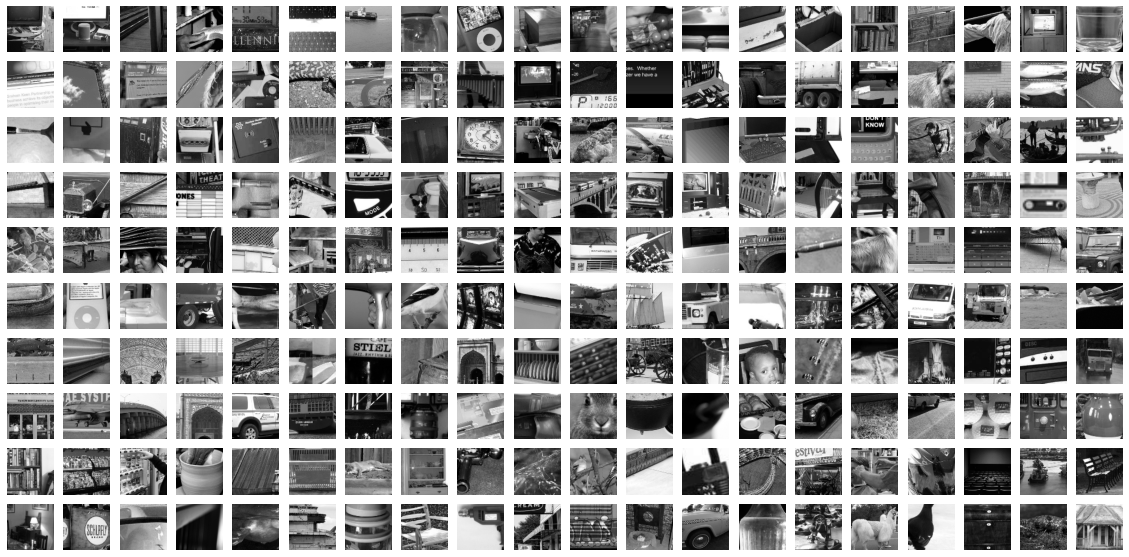

In [42]:
best_images_neuron5 = []
target_neuron_5 = []



activations = []
for index in range(0, len(train_images5)):
    activations.append(targets_list5[index][6])
    
sorted_act = sorted(activations)   

max_values = []
for i in range (1, 201):
    max_value = sorted_act[-i]
    if max_value not in max_values:
        max_values.append(max_value)
        print(max_value)
        indices = [i for i, x in enumerate(np.vstack(targets_list5)[:,6]) if x == max_value]

        for index in indices:
            best_images_neuron5.append(train_images5[index])
            target_neuron_5.append(targets_list5[index][6])
     
            
    
fig, axs = plt.subplots(10, 20, figsize=(20,10))

i = 0
for k in range(0, 10):
    for p in range(0, 20):
        axs[k][p].imshow(best_images_neuron5[i].squeeze(0), cmap='gray')
        i+=1
        axs[k][p].axis('off')
        
plt.savefig('200_best_img_fifth_best_neuron.png')

## PCA for gradient receptive fields:


### One problem is: Neurons often didn't 'LOOK' at the same images or didn't respond to the images strongly.

The following is an approach to extract the images of the 7 neurons of session: 3646222772876 with the best test correlation. I will calculate the gradient receptive fields for 500 of them - taking into account a PCA that takes all the images that were in the session as input

In [32]:
train_images_session = []
targets_list_session = []


for batch in dataloader["train"]['3646222772876']:
    images = batch.inputs
    responses = batch.targets

    for i in range(0, images.shape[0]):
        train_images_session.append(images[i])
        
        targets_list_session.append(responses[i])
        
print(len(train_images_session))

train_images = train_images_session[:500]
target_list = targets_list_session[:500]

12345


In [33]:
#unit indices for the 7 neurons with best test corr

key_list = [{'data_key': '3646222772876', 'unit_index': 3},{'data_key': '3646222772876', 'unit_index': 6},{'data_key': '3646222772876', 'unit_index': 4},{'data_key': '3646222772876', 'unit_index': 0},
            {'data_key': '3646222772876', 'unit_index': 7},{'data_key': '3646222772876', 'unit_index': 1},{'data_key': '3646222772876', 'unit_index': 2}]

len(key_list)

keys = [3,6,4,0,7,1,2]

### Get Gradient receptive fields of the 7 neurons within the same session:

In [34]:

n_images = len(train_images) # 100 images would also be fine

n_neurons = 7

RFs = torch.zeros(n_neurons, n_images,*train_images[0].shape[1:]) # preallocating RFs

img_x, img_y = train_images[0].shape[1:] # x and y dim on the image

    
#iterates through the 7 neurons with the best test correlation, selects the right session with ['data_key']
j = 0
for best in key_list:
    images = train_images     #taking same images for every neuron 
    #images = dataloader["train"][best['data_key']].dataset[:].inputs
    for i in range(0, n_images):
        x = images[i].reshape((1,1,images[i].shape[1], images[i].shape[2]))
       
        x = x.clone().detach().requires_grad_(True).to('cpu')
        optimizer = torch.optim.Adam([x], lr = 1.0)
        optimizer.zero_grad()
        
        r = model(x, data_key=best['data_key'], pretrained=True)


        r[0, best['unit_index']].backward(retain_graph=True)
        RFs[j, i] = x.grad.data
    
        x.grad.data.zero_()
    j += 1

(-0.5, 82.5, 82.5, -0.5)

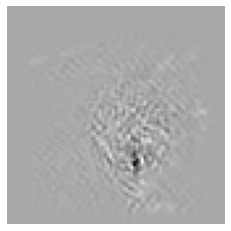

In [35]:
plt.imshow(RFs[0,6], cmap='gray')
plt.axis('off')

### Compute the per Neuron Eigenvalues of the img_x * img_y * n_rfs Matrix with kPCA

In [36]:
rfs_neuron_0 = RFs[0].cpu().detach().numpy().squeeze()


rfs_flattened = np.reshape(rfs_neuron_0,[n_images,-1])
rfs_flattened -= rfs_flattened.mean(axis=1, keepdims=True)

#Kernel matrix 
K = rfs_flattened @ rfs_flattened.T / rfs_flattened.shape[0]
uk, a = eig(K)
uc, a = map(np.real, (uk, a))

#Covariance
#C =  rfs_flattened.T @ rfs_flattened / rfs_flattened.shape[0]
#uc, v = eig(C)
#uk, v = map(np.real, (uc, v))

v2 = rfs_flattened.T @ a
v2 /= np.sqrt( (v2**2).sum(axis=0, keepdims=True)) # normalize each column to length 1 v/||v||_2
v3 = np.reshape(v2,(img_x, img_y, n_images)) # this will be the all eigenvalue RFs. v3[:,:,0] will be the one with the largest component

### Compute Ratio of First and Second Component
for simple cells, we expect that the first PC will be much larger than the second PC (because of phase invariance).
This won't be quite as relevant for mouse data, but why not.

In [37]:
eig_ratio = []
uks = []
RFs_np = RFs.cpu().detach().numpy()

for i in range(0, 7):

    rfs_flattened = RFs_np[i,::].squeeze()

    rfs_flattened = np.reshape(rfs_flattened,[n_images,-1])
    rfs_flattened -= rfs_flattened.mean(axis=1, keepdims=True)
    K = rfs_flattened @ rfs_flattened.T / rfs_flattened.shape[0]
    uk, a = eig(K)
    
    uk, a = map(np.real, (uk, a))
    
    uks.append(uk)
    #C = rfs_flattened.T @ rfs_flattened / rfs_flattened.shape[0]
    #uc, v = eig(C)
    #uc, v = map(np.real, (uc, v))

    eig_ratio.append(uk[1]/uk[0])


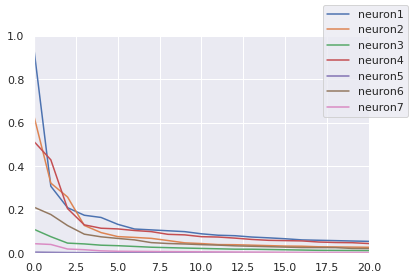

In [38]:
import seaborn as sns

with sns.axes_style('darkgrid'):
    fig, axs = plt.subplots()


axs.plot(uks[0], label = "neuron1")
axs.plot(uks[1], label = "neuron2")
axs.plot(uks[2], label = "neuron3")
axs.plot(uks[3], label = "neuron4")
axs.plot(uks[4], label = "neuron5")
axs.plot(uks[5], label = "neuron6")
axs.plot(uks[6], label = "neuron7")



axs.set_xlim(0, 20)
axs.set_ylim(0,1)
sns.despine(trim=True)
fig.legend()

plt.savefig('eigenvalues_per_neuron.png')

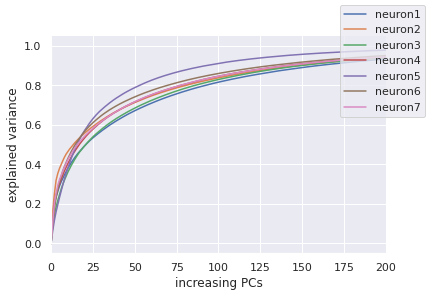

In [39]:
values = {}
num_neurons = 7

for j in range(0, num_neurons):
    value_list = []
    for i in range(0, n_images):
        
        value = np.sum(uks[j][:i])/np.sum(uks[j][:])   
        value_list.append(value)
  
    values[j] = value_list
 


with sns.axes_style('darkgrid'):
    fig, axs = plt.subplots()
axs.plot(values[0], label = "neuron1")
axs.plot(values[1], label = "neuron2")
axs.plot(values[2], label = "neuron3")
axs.plot(values[3], label = "neuron4")
axs.plot(values[4], label = "neuron5")
axs.plot(values[5], label = "neuron6")
axs.plot(values[6], label = "neuron7")


axs.set_xlim(0, 200)
axs.set_ylabel('explained variance')
axs.set_xlabel('increasing PCs')
sns.despine(trim=True)
fig.legend()

plt.savefig('explained_variance_same_images')

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


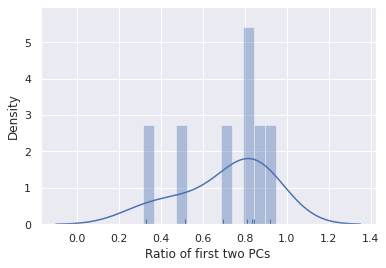

In [40]:
import seaborn as sns
import pandas as pd
sns.set()
x = pd.Series(eig_ratio, name="Ratio of first two PCs")
sns.distplot(x, np.linspace(0,1,20), rug=True)

plt.savefig("density_plot_without_repeats.png")

### Here the reconstructing part is coming

In [93]:

RFs_new = RFs.cpu().detach().numpy()

n_images = len(train_images)

Xpca_list = []
components_included = []
n_components = 250

for i in range(0, 7):

    n_comp = 0
    for value in values[i]:
        if value > 0.95:
            n_components = n_comp
            break
        n_comp += 1
        
        
    components_included.append(n_components)
    rfs_flattened = RFs_new[i,::].squeeze()

    rfs_flattened = np.reshape(rfs_flattened,[n_images,-1])
    

    rfs_mean = rfs_flattened.mean(axis=0, keepdims=True)
    rfs_flattened = rfs_flattened - rfs_mean
    
    K = rfs_flattened @ rfs_flattened.T / rfs_flattened.shape[0]
    uk, eig_vecs = eig(K)

    uk, eig_vecs = map(np.real, (uk, eig_vecs))
    
    ### ordering the eigenvalues and eigenvectors accendingly
    uk, eigvecs = uk[::-1], eig_vecs[:, ::-1]
    

    # get the n-most important eigenvectors:
    matrix_v = eig_vecs[:,0:n_components]

    ## P = V ` V ` t
    I = matrix_v.T @ matrix_v
    
    I2 = np.eye(I.shape[0])
    
    np.testing.assert_almost_equal(I, I2, decimal=6)
    
    V = matrix_v.T @ rfs_flattened
    V = V / np.sqrt( (V**2).sum(axis=1, keepdims=True))
    
    P = V.T @ V 

    ## reconstructed x = P * x
    Xpca = rfs_flattened @ P
    
    
    #bringing images back in shape
    Xpca = np.reshape(Xpca,(n_images,img_x, img_y)) # this will be the all eigenvalue RFs. v3[:,:,0] will be the one with the largest component
    
    Xpca_list.append(Xpca)


    #decode_matrices.append(v3.copy())

In [94]:
np_train_images =np.concatenate(train_images, axis=0 )

print(np_train_images.shape)

(500, 83, 83)


In [ ]:
fig, axs = plt.subplots(30, 6, figsize=(20,180))
j = 0 #neuron
i = 0
max_transparency = 0.65

threshold_value = 1e-4 # only values above that will be shown. I guess it's the best to the the np.abs(gradRF) when setting the alphas to zero

i = 100
for k in range(0, 30):
   
    for p in range(0, 6):
    
        max_intensity=np.max(np.abs(Xpca_list[p][i,:,:]))
        min_intensity=np.min(np.abs(Xpca_list[p][i,:,:]))
      

        axs[k][p].title.set_text('neuron: ' + str(p) + ', activation: '+ str(int(targets_list_session[i][p])))

        #axs[k][p].imshow(Xpca_list[p][i,:,:] ,cmap=  'viridis', vmin=-max_intensity, vmax = max_intensity)
        #axs[k][p].axis('off')
        
        alpha_values = np.ones_like(Xpca_list[p][i,:,:]) * max_transparency
        
        threshold_value = np.percentile(np.abs(Xpca_list[p][i,:,:]), 80)
        alpha_values[np.abs(Xpca_list[p][i,:,:])<threshold_value] = 0
        
        axs[k][p].imshow(Xpca_list[p][i,:,:] , alpha=alpha_values, cmap='viridis', vmin=-max_intensity, vmax = max_intensity)
        axs[k][p].imshow(train_images[i].squeeze(0) ,cmap=  'gray'   , alpha = 0.7)
        axs[k][p].axis('off')
        #axs[k][6].axis('off')

    
    i+=1

        
plt.savefig('comparision_of_5_neurons')


### With a different colormap:

In [ ]:
fig, axs = plt.subplots(30, 7, figsize=(20,180))
j = 0 #neuron
i = 0
max_transparency = 0.65

threshold_value = 1e-4 # only values above that will be shown. I guess it's the best to the the np.abs(gradRF) when setting the alphas to zero

i = 0
for k in range(0, 30):
   
    for p in range(0, 6):
    
        max_intensity=np.max(np.abs(Xpca_list[p][i,:,:]))
        min_intensity=np.min(np.abs(Xpca_list[p][i,:,:]))
      

        axs[k][p].title.set_text('neuron: ' + str(p) + ', activation: '+ str(int(targets_list_session[i][p])))

        
        alpha_values = np.ones_like(Xpca_list[p][i,:,:]) * max_transparency
        
        threshold_value = np.percentile(np.abs(Xpca_list[p][i,:,:]), 90)
        alpha_values[np.abs(Xpca_list[p][i,:,:])<threshold_value] = 0
        
        axs[k][p].imshow(Xpca_list[p][i,:,:] , alpha=0.8, cmap='seismic', vmin=-max_intensity, vmax = max_intensity)
        
        axs[k][6].imshow(train_images[i].squeeze(0) ,cmap=  'gray'  )
        axs[k][p].axis('off')
        axs[k][6].axis('off')

    
    i+=1

        
plt.savefig('comparision_of_5_neurons')